# Exploratory Data Analysis

Spencer Brothers

IS 6812 Spring 2025

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Exploring the Target Variable

Because application_test.csv is the same schema as the train file (without the target), we'll look at the train file only.

*See README if pulling project from GitHub Repository*

In [37]:
# read the main file with the target into a pandas dataframe
app_train = pd.read_csv('data/application_train.csv')
app_test = pd.read_csv('data/application_test.csv')
# get info on the table
app_train.info()
app_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


There are 122 columns and 307,511 rows in the training set. There are 121 columns and 48,744 rows in the testing set. Many columns are just checking if applicants submitted certain documents (according to kaggle). The "object" dtype columns are really strings. Let's take a closer look at the target. 

In [46]:
# find what columns are present in the train set that aren't present in the testing set and vice-versa
print(app_train.columns[~app_train.columns.isin(app_test.columns)].values)
print(app_test.columns[~app_test.columns.isin(app_train.columns)].values)

['TARGET']
[]


The only difference between the two schemas is that the training set contains the target, while the testing set does not.

   counts  proportions
0  282686     0.919271
1   24825     0.080729


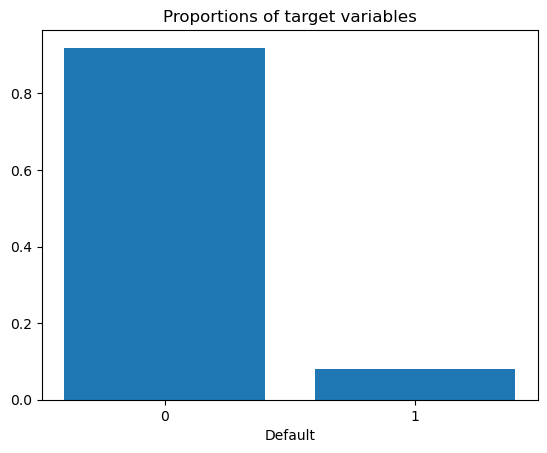

In [7]:
# Find the distribution of the target variable
target_dist = app_train.value_counts('TARGET')
target_props = pd.DataFrame({
    'counts': target_dist.values,
    'proportions': target_dist.values/len(app_train)})
print(target_props)
# plot the proportions
plt.bar(target_props.index.astype(str),target_props['proportions'])
plt.title('Proportions of target variables')
plt.xlabel('Default')
plt.show()

There's a very large imbalance in the target classes, with only about 8.1% of applicants defaulting. A simple majority class classifier would classify all applicants as not defaulting (with an accuracy of about 91.9%), which would be detrimental to the applicants who would default as well as Home Credit. 

## Exploring Relationships Between Target and Predictors

- TODO: Explore the relationship between target and predictors, looking for potentially strong predictors that could be included later in a model.
    - The skimr package in R has some great data exploration tools, and the janitor package has utilities that will simplify data cleaning.


## Missing data in application_{train|test}.csv

- TODO: Explore the scope of missing data in application_{train|test}.csv and come up with possible solutions. Remove rows?  Remove columns?  Impute?

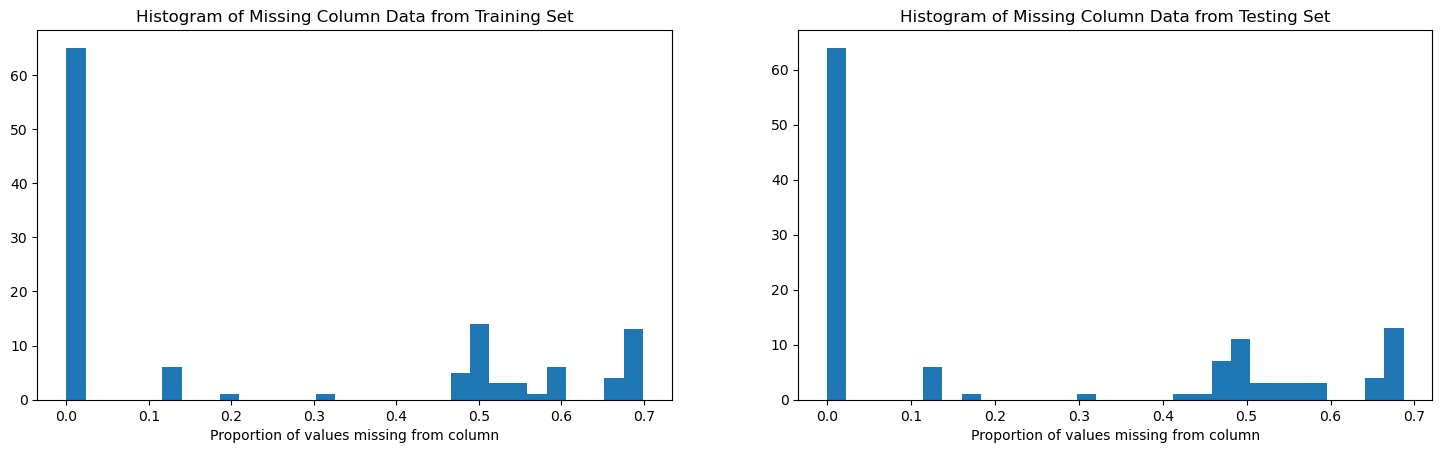

67 columns contain missing values. 

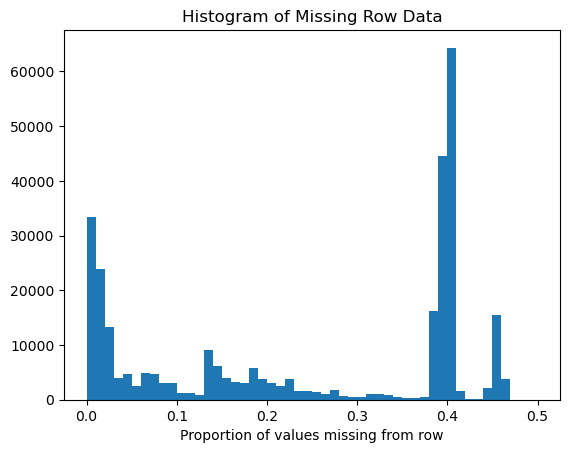

In [60]:
# Plot a histogram showing the distribution of missing data among the 122 columns
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(18)
axs[0].hist(app_train.isna().sum()/len(app_train), bins=30)
axs[1].hist(app_test.isna().sum()/len(app_test), bins=30)
axs[0].set_title('Histogram of Missing Column Data from Training Set')
axs[1].set_title('Histogram of Missing Column Data from Testing Set')
axs[0].set_xlabel('Proportion of values missing from column')
axs[1].set_xlabel('Proportion of values missing from column')

plt.show()

# get info on columns missing values
print(f'{app_train.isna().any().sum()} columns contain missing values. ', end='')
# print(f'These rows are:\n {app_train.columns[app_train.isna().any()].values}')

plt.hist(app_train.isna().mean(axis=1), bins=50)
plt.title('Histogram of Missing Row Data')
plt.xlabel('Proportion of values missing from row')
plt.show()

## Investigating Problems in the Data

- TODO: Be alert to problems in the data.  Do the values make sense? Are there mistaken values that should be cleaned or imputed? (Note that outliers are not necessarily mistakes. Check APM for advice on how to handle outliers for a predictive project.) Are there columns with near-zero or zero variance?

## Transforming Input Data

- TODO: Will the input data need to be transformed in order to be used in a model? You might answer this question differently for different models. (For example, some models might accept factor variables, others might not.) You can put off answering this question for now,  but you should begin thinking about it. Check APM for advice.

## Exploring Joined Data

- TODO: Join application_{train|test}.csv with transactional data in, for example, bureau.csv or previous_application.csv. This will require aggregating the transactional data to have the same grain as the application data.
- TODO: Explore the joined transactional data.  Do some of the added columns show promise in predicting default?